In [2]:
import pandas as pd

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def summarize_change_types(df):
    return df["ChangeType"].value_counts().sort_index()

def compare_change_type_stats(path_legacy, path_proposed):
    df_legacy = load_and_classify_routing_log(path_legacy)
    df_proposed = load_and_classify_routing_log(path_proposed)

    summary_legacy = summarize_change_types(df_legacy)
    summary_proposed = summarize_change_types(df_proposed)

    df_compare = pd.DataFrame({
        "Legacy": summary_legacy,
        "Proposed": summary_proposed
    }).fillna(0).astype(int)

    return df_compare

def estimate_rrep_success_rate(routing_log_path, recovery_log_path, change_type, interval=1.0):
    df = load_and_classify_routing_log(routing_log_path)
    changed_df = df[df["ChangeType"] == change_type][["Time", "Node", "Destination"]]

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"]

    success = 0
    total = 0

    for _, row in changed_df.iterrows():
        t_start = row["Time"]
        t_end = t_start + interval
        dest = str(row["Destination"])

        matched = rrep_df[
            (rrep_df["Destination"].astype(str) == dest) &
            (rrep_df["Time"] >= t_start) & (rrep_df["Time"] <= t_end)
        ]

        total += 1
        if not matched.empty:
            success += 1

    rate = (success / total) * 100 if total > 0 else 0
    return rate

legacy_routing = "Legacy/aodv_routing_log.csv"
proposed_routing = "Proposed/aodv_routing_log.csv"
legacy_recovery = "Legacy/recovery_log.csv"
proposed_recovery = "Proposed/recovery_log.csv"

df_compare = compare_change_type_stats(legacy_routing, proposed_routing)
print("=== 변화 유형 통계 비교 ===")
print(df_compare)

print("\n=== RREP 수신률 비교 (변화 직후 1초 이내) ===")
change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]

for change in change_types:
    legacy_rate = estimate_rrep_success_rate(legacy_routing, legacy_recovery, change)
    proposed_rate = estimate_rrep_success_rate(proposed_routing, proposed_recovery, change)

    print(f"[{change}]")
    print(f"  Legacy   : {legacy_rate:.2f}%")
    print(f"  Proposed : {proposed_rate:.2f}%\n")


=== 변화 유형 통계 비교 ===
              Legacy  Proposed
ChangeType                    
Hop+NextHop     1311      3958
HopOnly          288       661
LifeTimeOnly  675482    681442
NextHopOnly      934      2141

=== RREP 수신률 비교 (변화 직후 1초 이내) ===
[Hop+NextHop]
  Legacy   : 11.75%
  Proposed : 21.45%

[HopOnly]
  Legacy   : 18.06%
  Proposed : 30.11%

[NextHopOnly]
  Legacy   : 11.88%
  Proposed : 17.28%



In [ ]:
import bisect
import pandas as pd

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def summarize_change_types(df):
    return df["ChangeType"].value_counts().sort_index()

def compare_change_type_stats(path_legacy, path_proposed):
    df_legacy = load_and_classify_routing_log(path_legacy)
    df_proposed = load_and_classify_routing_log(path_proposed)

    summary_legacy = summarize_change_types(df_legacy)
    summary_proposed = summarize_change_types(df_proposed)

    df_compare = pd.DataFrame({
        "Legacy": summary_legacy,
        "Proposed": summary_proposed
    }).fillna(0).astype(int)

    return df_compare

def estimate_rrep_success_rate_binary_search(
    routing_log_path, recovery_log_path, change_type="Hop+NextHop", interval=1.0
):
    df = load_and_classify_routing_log(routing_log_path)
    df = df[df["ChangeType"] == change_type][["Time", "Destination"]].copy()
    df["Destination"] = df["Destination"].astype(str)

    if df.empty:
        return 0.0

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"][["Time", "Destination"]].copy()
    rrep_df["Destination"] = rrep_df["Destination"].astype(str)

    rrep_dict = {}
    for dest, group in rrep_df.groupby("Destination"):
        rrep_dict[dest] = sorted(group["Time"].tolist())

    total = len(df)
    success = 0

    for _, row in df.iterrows():
        t = row["Time"]
        d = row["Destination"]

        if d not in rrep_dict:
            continue

        times = rrep_dict[d]
        idx = bisect.bisect_left(times, t)
        if idx < len(times) and times[idx] <= t + interval:
            success += 1

    return (success / total) * 100 if total > 0 else 0


legacy_routing = "Legacy/aodv_routing_log.csv"
proposed_routing = "Proposed/aodv_routing_log.csv"
legacy_recovery = "Legacy/recovery_log.csv"
proposed_recovery = "Proposed/recovery_log.csv"

df_compare = compare_change_type_stats(legacy_routing, proposed_routing)
print("=== 변화 유형 통계 비교 ===")
print(df_compare)

print("\n=== RREP 수신률 비교 (변화 직후 1초 이내) ===")
change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]

for change in change_types:
    legacy_rate = estimate_rrep_success_rate_binary_search(
        legacy_routing, legacy_recovery, change
    )
    proposed_rate = estimate_rrep_success_rate_binary_search(
        proposed_routing, proposed_recovery, change
    )

    print(f"[{change}]")
    print(f"  Legacy   : {legacy_rate:.2f}%")
    print(f"  Proposed : {proposed_rate:.2f}%\n")



=== 변화 유형 통계 비교 ===
              Legacy  Proposed
ChangeType                    
Hop+NextHop     1311      3958
HopOnly          288       661
LifeTimeOnly  675482    681442
NextHopOnly      934      2141

=== RREP 수신률 비교 (변화 직후 1초 이내) ===
[Hop+NextHop]
  Legacy   : 11.75%
  Proposed : 21.45%

[HopOnly]
  Legacy   : 18.06%
  Proposed : 30.11%

[NextHopOnly]
  Legacy   : 11.88%
  Proposed : 17.28%



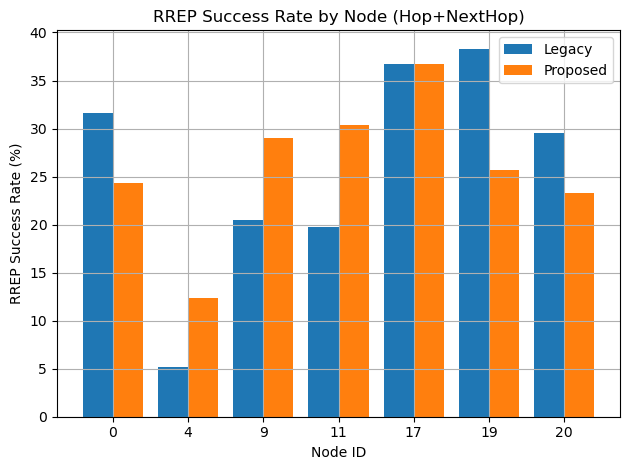

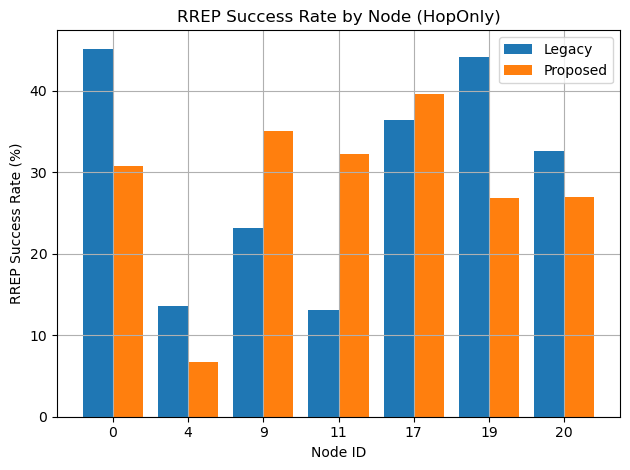

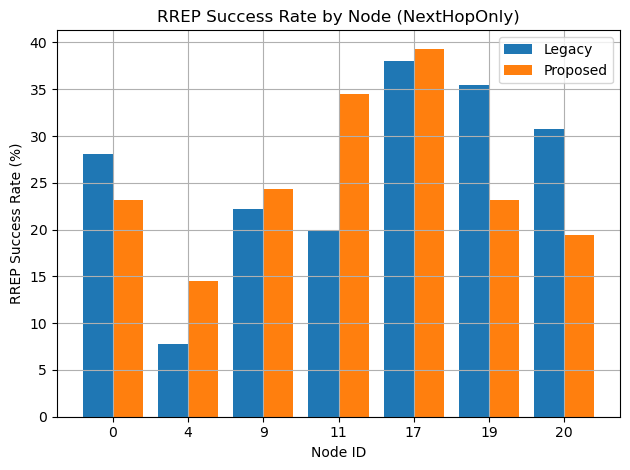

In [10]:
import os
import bisect
import pandas as pd
import matplotlib.pyplot as plt

nodes = [0, 4, 6, 7, 9, 10, 11, 17, 19, 20]
change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]
interval = 1.0

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/고밀도/고속/"

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def estimate_rrep_success_rate(routing_log_path, recovery_log_path, change_type, interval):
    if not os.path.exists(routing_log_path) or not os.path.exists(recovery_log_path):
        return None

    df = load_and_classify_routing_log(routing_log_path)
    df = df[df["ChangeType"] == change_type][["Time", "Destination"]].copy()
    df["Destination"] = df["Destination"].astype(str)

    if df.empty:
        return 0.0

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"][["Time", "Destination"]].copy()
    rrep_df["Destination"] = rrep_df["Destination"].astype(str)

    rrep_dict = {}
    for dest, group in rrep_df.groupby("Destination"):
        rrep_dict[dest] = sorted(group["Time"].tolist())

    total = len(df)
    success = 0

    for _, row in df.iterrows():
        t = row["Time"]
        d = row["Destination"]
        if d not in rrep_dict:
            continue
        times = rrep_dict[d]
        idx = bisect.bisect_left(times, t)
        if idx < len(times) and times[idx] <= t + interval:
            success += 1

    return (success / total) * 100 if total > 0 else 0.0

results = {change: [] for change in change_types}
valid_nodes = []

for node_id in nodes:
    legacy_routing = os.path.join(base_path, "기존", str(node_id), "aodv_routing_log.csv")
    legacy_recovery = os.path.join(base_path, "기존", str(node_id), "recovery_log.csv")
    proposed_routing = os.path.join(base_path, "제안", str(node_id), "aodv_routing_log.csv")
    proposed_recovery = os.path.join(base_path, "제안", str(node_id), "recovery_log.csv")

    # 파일 하나라도 없으면 패스
    if not all(map(os.path.exists, [legacy_routing, legacy_recovery, proposed_routing, proposed_recovery])):
        continue

    valid_nodes.append(node_id)

    for change in change_types:
        legacy_rate = estimate_rrep_success_rate(legacy_routing, legacy_recovery, change, interval)
        proposed_rate = estimate_rrep_success_rate(proposed_routing, proposed_recovery, change, interval)
        results[change].append((legacy_rate, proposed_rate))

# 시각화
for change in change_types:
    if change not in results or not results[change]:
        continue

    legacy_rates, proposed_rates = zip(*results[change])
    x = range(len(valid_nodes))
    plt.figure()
    plt.bar([i - 0.2 for i in x], legacy_rates, width=0.4, label="Legacy")
    plt.bar([i + 0.2 for i in x], proposed_rates, width=0.4, label="Proposed")
    plt.xticks(x, [str(n) for n in valid_nodes])
    plt.xlabel("Node ID")
    plt.ylabel("RREP Success Rate (%)")
    plt.title(f"RREP Success Rate by Node ({change})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [11]:
print("=== 변화 유형별 평균 RREP 수신률 ===")
for change in change_types:
    if not results[change]:
        continue
    legacy_rates, proposed_rates = zip(*results[change])
    avg_legacy = sum(legacy_rates) / len(legacy_rates)
    avg_proposed = sum(proposed_rates) / len(proposed_rates)
    print(f"[{change}]")
    print(f"  Legacy 평균   : {avg_legacy:.2f}%")
    print(f"  Proposed 평균 : {avg_proposed:.2f}%\n")


=== 변화 유형별 평균 RREP 수신률 ===
[Hop+NextHop]
  Legacy 평균   : 25.95%
  Proposed 평균 : 25.94%

[HopOnly]
  Legacy 평균   : 29.74%
  Proposed 평균 : 28.33%

[NextHopOnly]
  Legacy 평균   : 26.00%
  Proposed 평균 : 25.49%

